In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


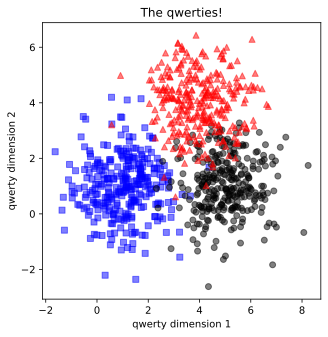

In [3]:
n_per_clust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

a = [ A[0]+np.random.randn(n_per_clust)*blur, A[1]+np.random.randn(n_per_clust)*blur ]
b = [ B[0]+np.random.randn(n_per_clust)*blur, B[1]+np.random.randn(n_per_clust)*blur ]
c = [ C[0]+np.random.randn(n_per_clust)*blur, C[1]+np.random.randn(n_per_clust)*blur ]

labels_np = np.hstack(( np.zeros((n_per_clust)),
                        np.ones((n_per_clust)),
                      1+np.ones((n_per_clust))))

data_np = np.hstack((a,b,c)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [5]:
print(f"There are {len(train_loader)} batches, each with {batch_size} samples.")

There are 50 batches, each with 16 samples.


In [16]:
def create_model():
    class ANN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,8)
            
            self.fc1 = nn.Linear(8,8)
            
            self.output = nn.Linear(8,3)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    model = ANN()
    
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=.01)
    
    return model, loss_fun, optimizer

In [17]:
model, loss_fun, optimizer = create_model()
print(model)

input_ = torch.randn(10,2)
model(input_)

ANN(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.5116,  0.1310, -0.2110],
        [-0.4129,  0.0724, -0.2012],
        [-0.4528,  0.0765, -0.2030],
        [-0.4199,  0.1590, -0.2498],
        [-0.3280,  0.0700, -0.1934],
        [-0.4471,  0.1100, -0.2086],
        [-0.3837,  0.0984, -0.2316],
        [-0.3351,  0.1360, -0.2644],
        [-0.2919,  0.0637, -0.3107],
        [-0.5097,  0.0986, -0.2050]], grad_fn=<AddmmBackward0>)

In [23]:
def train_model():
    num_of_epochs = 100
    
    model, loss_fun, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        model.train()
        
        batch_acc = []
        batch_loss = []
        for X,y in train_loader:
            yHat = model(X)
            loss = loss_fun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
        train_acc.append(np.mean(batch_acc))
        
        losses[epoch] = np.mean(batch_loss)
        
        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)
            
        test_acc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))    
        
    return train_acc, test_acc, losses, model

In [24]:
train_acc, test_acc, losses, net = train_model()

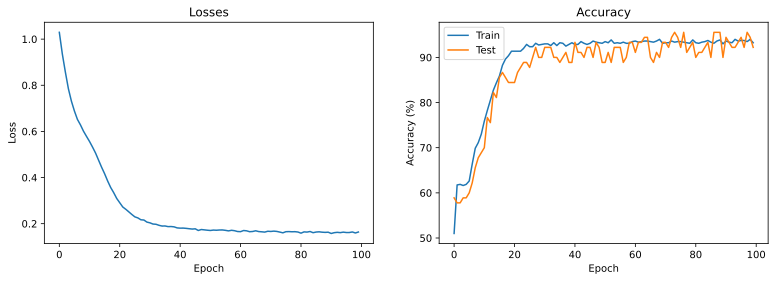

In [25]:
fig, ax = plt.subplots(1,2, figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

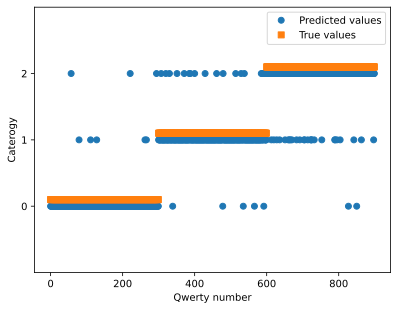

In [32]:
yHat = net(data)
predictions = torch.argmax(yHat, axis=1)

plt.plot(predictions, 'o', label='Predicted values')
plt.plot(labels+.1, 's', label='True values')
plt.xlabel('Qwerty number')
plt.ylabel('Caterogy')
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

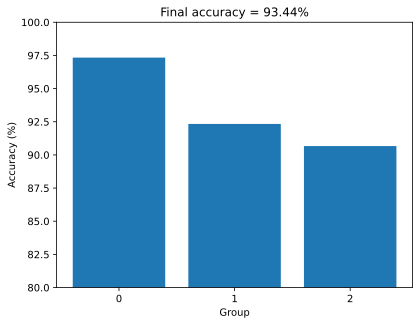

In [33]:
accuracy = (predictions == labels).float()

total_acc = torch.mean(100*accuracy).item()

accuracy_by_group = np.zeros(3)
for i in range(3):
    accuracy_by_group[i] = 100*torch.mean(accuracy[labels==i])
    
plt.bar(range(3), accuracy_by_group)
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f"Final accuracy = {total_acc:.2f}%")
plt.show()

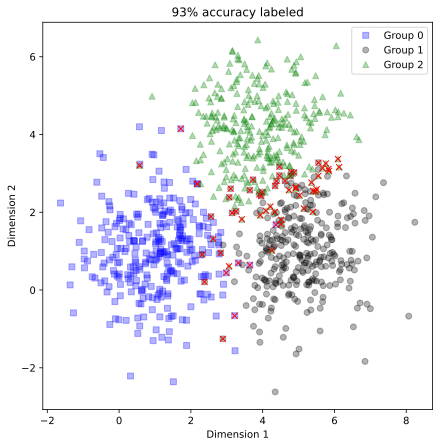

In [35]:
color_shapes = [ 'bs', 'ko', 'g^' ]

fig = plt.figure(figsize=(7,7))

for i in range(3):
    plt.plot(data[labels==i, 0], data[labels==i, 1], color_shapes[i], alpha=.3, label=f"Group {i}")
    idx_err = (accuracy == 0) & (labels == i)
    plt.plot(data[idx_err, 0], data[idx_err, 1], 'rx')
    
plt.title(f"{total_acc:.0f}% accuracy labeled")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()